In [1]:
import random
import math
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn import svm
import numpy as np

In [2]:
class FireflyAlgorithm():

    def __init__(self, function):
        #Initialize parameters of the firefly algorithm
        self.D = 111  # Number of dimensions. This is equivalent to the number of features in the dataset
        self.NP = 30  # This is the number of fireflies in the model
        self.nFES = 1  # number of function evaluations (repeate number)
        self.alpha = 1  # alpha parameter,(randomization parameter)
        self.betamin = 1  # Brightness index
        self.gamma = 1  # gamma parameter (light intensity coefficency)
        # sort of fireflies according to fitness value
        self.Index = [0] * self.NP
        self.Fireflies = [[np.random.rand() for i in range(self.D)] for j in range(self.NP)]  # firefly agents,
        self.Fireflies_tmp = [[np.random.rand() for i in range(self.D)] for j in range(
            self.NP)]  # intermediate pop
        self.Fitness = [0.0] * self.NP  # fitness values (Accuracy)
        self.I = [0.0] * self.NP  # light intensity
        self.nbest = [0.0] * self.NP  # the best solution found so far
        self.LB = 0  # lower bound
        self.UB = 1  # upper bound
        self.fbest = None  # the best
        self.evaluations = 0
        self.Fun = function

    def alpha_new(self, a):
        delta = 1.0 - math.pow((math.pow(10.0, -4.0) / 0.9), 1.0 / float(a))
        return (1 - delta) * self.alpha

    def sort_ffa(self):  # implementation of bubble sort

        for i in range(self.NP):
            self.Index[i] = i

        for i in range(0, (self.NP - 1)):
            j = i + 1
            for j in range(j, self.NP):
                if (self.I[i] > self.I[j]):
                    z = self.I[i]  # exchange attractiveness
                    self.I[i] = self.I[j]
                    self.I[j] = z
                    z = self.Fitness[i]  # exchange fitness
                    self.Fitness[i] = self.Fitness[j]
                    self.Fitness[j] = z
                    z = self.Index[i]  # exchange indexes
                    self.Index[i] = self.Index[j]
                    self.Index[j] = z


    def replace_ffa(self):  # replace the old population according to the new Index values
        # copy original population to a temporary area
        for i in range(self.NP):
            for j in range(self.D):
                self.Fireflies_tmp[i][j] = self.Fireflies[i][j]

        # generational selection in the sense of an EA
        for i in range(self.NP):
            for j in range(self.D):
                self.Fireflies[i][j] = self.Fireflies_tmp[self.Index[i]][j]

    def FindLimits(self, k):
        for i in range(self.D):
            if self.Fireflies[k][i] < self.LB:
                self.Fireflies[k][i] = self.LB
            if self.Fireflies[k][i] > self.UB:
                self.Fireflies[k][i] = self.UB

    def move_ffa(self):
        for i in range(self.NP):
            scale = abs(self.UB - self.LB)
            for j in range(self.NP):
                r = 0.0
                for k in range(self.D):
                    r += (self.Fireflies[i][k] - self.Fireflies[j][k]) * \
                        (self.Fireflies[i][k] - self.Fireflies[j][k])
                r = math.sqrt(r)
                if self.I[i] > self.I[j]:  # brighter and more attractive
                    beta0 = 1.0
                    beta = (beta0 - self.betamin) * math.exp(-self.gamma * math.pow(r, 2.0)) + self.betamin
                    for k in range(self.D):
                        r = random.uniform(0, 1)
                        tmpf = self.alpha * (r - 0.5) * scale
                        self.Fireflies[i][k] = self.Fireflies[i][
                            k] * (1.0 - beta) + self.Fireflies_tmp[j][k] * beta + tmpf
            self.FindLimits(i)

    def Run(self):
        while self.evaluations < self.nFES:

            # optional reducing of alpha
            #self.alpha = self.alpha_new(self.nFES/self.NP)
            self.evaluations = self.evaluations + 1
            # evaluate new solutions
            for i in range(self.NP):
                self.Fitness[i] = self.Fun(self.Fireflies[i])

                self.I[i] = self.Fitness[i]


            # ranking fireflies by their light intensit
            self.sort_ffa()
            # replace old population
            self.replace_ffa()
            # move all fireflies to the better locations
            self.move_ffa()

        bestFirefly = self.Fireflies[self.NP - 1]

        return bestFirefly

In [3]:
Phishing = pd.read_csv ("C:/Users/hp/Desktop/NEWDATA.csv")
Phishing.head(2)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1


In [46]:
Phishing.to_excel(r'C:\Users\hp\Desktop\Firefly_Data.xlsx', sheet_name='FirelyData', index = True)

In [4]:

y = Phishing['phishing'].values
X = Phishing.drop('phishing', axis=1).values
X

array([[3., 0., 0., ..., 0., 0., 0.],
       [5., 0., 1., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 0., 0.],
       [4., 1., 0., ..., 0., 0., 0.]])

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
def evaluation(feature_possibilities):
        feature_possibilities = np.round(feature_possibilities)

        feature_possibilities = feature_possibilities > np.float32(0.7)

        selectedX = X[:, feature_possibilities]
        #Create a Gaussian Classifier
        s=RandomForestClassifier(n_estimators=400)

        loocv = LeaveOneOut()
        evaluation = cross_val_score(s, selectedX, y,  cv=loocv)

        return evaluation.mean()

In [11]:
Algorithm = FireflyAlgorithm(evaluation)

In [13]:
Best = Algorithm.Run()

In [14]:
a = np.round(Best)

Feature_Filter = a > np.float32(0.7)

print(Feature_Filter)

[False False False  True  True  True False  True False  True False  True
  True  True False  True False  True False False False False False False
 False  True False False False  True  True False  True False  True  True
 False  True  True  True False  True  True False False False  True  True
  True  True False False  True False  True  True  True  True  True  True
  True  True  True False  True False False  True False False  True False
  True False  True False  True False False  True False  True  True False
 False False False  True False  True False  True  True False  True False
 False  True False False False  True  True  True  True  True  True False
 False False False]


In [15]:
#The actual feature selection where best features are given the label 'TRUE'
#Not best features are given the label 'FALSE'
#Best features have an objective score greater than 0.7
Feature_Filter_Appended_to_main_Data = pd.DataFrame(Feature_Filter)
New_Features = Feature_Filter_Appended_to_main_Data.T
New_Features

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,False,False,False,True,True,True,False,True,False,True,...,True,True,True,True,True,True,False,False,False,False


In [16]:
X_new = pd.DataFrame(X)
New_Features.to_excel(r'C:\Users\hp\Desktop\Features_Random.xlsx', sheet_name='Features', index = True)

In [17]:
print(Best)

[0.4197495726519004, 0.27964248805375524, 0.03741167434839965, 0.6056542513605243, 0.8210302466364459, 0.5203203346697883, 0.16746168213515822, 0.9467451760747804, 0.4948042233984442, 0.5994892607051847, 0.40926450257451064, 0.8453471882154757, 0.5306975548564796, 0.9019937789359368, 0.03422445566651866, 0.5168367877578466, 0.14061874921081596, 0.5337651572529444, 0.4404804136253062, 0.20590871185125492, 0.3337833272983397, 0.03315502980758345, 0.47804907997187374, 0.03177829191688564, 0.010834214971579548, 0.5724388935857518, 0.1569563983224228, 0.06687357085672452, 0.4397603787601796, 0.7703134387478203, 0.7348603011682175, 0.15668504305011677, 0.9701752512696992, 0.33346058091832675, 0.9895556232169289, 0.6280183350295353, 0.005408226030754082, 0.7344566269238775, 0.9279955444120443, 0.9678302649220674, 0.4849734460569153, 0.8083004840275507, 0.8128876327674136, 0.10215670743856964, 0.2220585645561245, 0.21299619769973255, 0.9186704730418396, 0.844830037963625, 0.9937230699469756, 0

In [18]:
New_Best = pd.DataFrame(Best)
New_Best.head(2)

,0
0,0.419750
1,0.279642


In [19]:
true_number = np.array(np.unique(Feature_Filter, return_counts=True)).T
bestX = X[:, Feature_Filter]
print(true_number)

[[ 0 55]
 [ 1 56]]


In [20]:
#Elimination of FALSE features was done manually in Excel
#The new dataset with only best features is loaded in this cell
#As per the true number above, the number of best features with scores above 70% was 59
Filtered_Dataset = pd.read_csv ("C:/Users/hp/Desktop/SELECTED_RANDOM_FOREST.csv")
Filtered_Dataset.head(3)

,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_and_url,qty_space_url,qty_comma_url,qty_plus_url,qty_asterisk_url,qty_dollar_url,qty_tld_url,...,qty_percent_params,tld_present_params,time_response,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,phishing
0,1,0,0,0,0,0,0,0,0,1,...,-1,-1,0.207316,-1,1,2,0,892,0,1
1,3,0,3,2,0,0,0,0,0,3,...,0,0,0.499566,150,1,2,1,9540,1,1
2,1,0,0,0,0,0,0,0,0,1,...,-1,-1,0.935901,-1,1,2,3,589,1,0


In [21]:
y_data = Filtered_Dataset['phishing']
X_data = Filtered_Dataset.drop('phishing', axis=1)

In [22]:
y_data.head(2)

0    1
1    1
Name: phishing, dtype: int64

In [23]:
##We will use two machine learning algorithms to perform classification
#The first one is the random forest classifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [24]:
# Split into training and test set 
##In this cell, we use the random forest classifier to predict whether a link is phishing or not
X_train, X_test, y_train, y_test = train_test_split( 
             X_data, y_data, test_size = 0.4,random_state=5)

In [25]:
##In this cell, we use the random forest classifier to predict whether a link is phishing or not
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=400)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [26]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9355828220858896


In [27]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[405  33]
 [  9 205]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       438
           1       0.86      0.96      0.91       214

    accuracy                           0.94       652
   macro avg       0.92      0.94      0.93       652
weighted avg       0.94      0.94      0.94       652



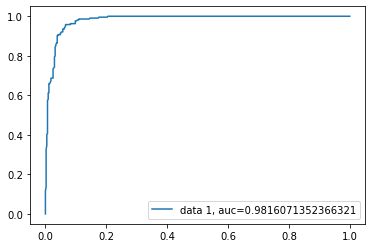

In [28]:
import matplotlib.pyplot as plt
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()